In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
start_year = 1975
end_year = 2021

columns = ['IMAGE Region Name', 'time', 'NGFBFC']

In [3]:
def ngfbfc_processing(df):
    try:
        if "type" in df.columns.to_list():
            df = df.rename(columns={"type": "NGFBFC"}) 

        if 'NGFBFC' in df.columns:
            df['NGFBFC'] = df['NGFBFC'].str.lower()
            df['NGFBFC'] = df['NGFBFC'].replace("oil & palm fruit", "palm oil")
            df['NGFBFC'] = df['NGFBFC'].replace("other non-food & luxury & spices", "non food, luxury, spices")
            df['NGFBFC'] = df['NGFBFC'].replace('other temperate cereals', 'temperate cereals')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def region_processing(df):
    try:
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Kazakhstan region', 'Central Asia').replace('C. Europe', 'Central Europe').replace('E. Africa', 'Eastern Africa').replace('N. Africa', 'Northern Africa')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest C. America', 'Central America').replace('Rest S. Africa', 'Rest of Southern Africa').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Rest S. Asia', 'Rest of South Asia').replace('SE. Asia', 'Southeast Asia').replace('Rest S. America', 'Rest of South America')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('W. Africa', 'Western Africa').replace('W. Europe', 'Western Europe').replace('Russia', 'Russia region')
        df['IMAGE Region Name'] = df['IMAGE Region Name'].replace('Indonesia', 'Indonesia region').replace('China', 'China region').replace('Korea', 'Korea region')
        return df
    except Exception as e:
        print(f"error: {e}")
        return df

def custom_mean(x):
  """Calculates the mean of non-zero values."""
  non_zero_values = x[x > 0]
  return non_zero_values.sum() / len(non_zero_values) if len(non_zero_values) > 0 else 0


def get_top_n(df, category_col, value_col, n=3):
    return df.groupby(category_col).apply(lambda x: x.nlargest(n, value_col)).reset_index(drop=True)

def get_angular_position(NGFBFC_name, NGFBFCs_list):
    """Calculate the angular position of a NGFBFC in the chart"""
    idx = NGFBFCs_list.index(NGFBFC_name)
    return (idx * 360.0 / len(NGFBFCs_list) + 90) % 360

In [8]:
GECH4RI = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECH4RI_rice_category_annual_gtco2eq.xlsx")
GECO2AB_CH4 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECO2AB_crop_category_annual_gtco2eq_CH4_13Jan.xlsx")
GECO2AB_N2O = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GECO2AB_crop_category_annual_gtco2eq_N2O_13Jan.xlsx")
GEC2OLC = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GEN2OLC_crop_category_annual_gtco2eq.xlsx")
GEN2ORE = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GEN2ORE_crop_category_annual_gtco2eq_13Jan.xlsx")
GFERTYN = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GFERTSYN_crop_category_annual_gtco2eq.xlsx")
GMANURE = pd.read_excel("D:/kerja/asisten riset/code v/review/data/GMANURE_crop_category_annual_gtco2eq.xlsx")
LUC_total = pd.read_excel("D:/kerja/asisten riset/code v/review/data/LUC_total_crop_category_annual_gtco2eq.xlsx")
peat_CH4 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_CH4_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_CO2 = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_CO2_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_DOC = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_DOC_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
peat_N2O = pd.read_excel("D:/kerja/asisten riset/code v/review/data/peat_N2O_crop_category_annual_gtco2eq_v2_13Jan.xlsx")
country_code = pd.read_excel("D:/kerja/asisten riset/vol/milkunC/achaidir/LUH2 2022/ISO-3166-Country-Code_Final.xlsx", engine="openpyxl")

GECH4RI = ngfbfc_processing(GECH4RI)
GECO2AB_CH4 = ngfbfc_processing(GECO2AB_CH4)
GECO2AB_N2O = ngfbfc_processing(GECO2AB_N2O)
GEC2OLC = ngfbfc_processing(GEC2OLC)
GEN2ORE = ngfbfc_processing(GEN2ORE)
GFERTYN = ngfbfc_processing(GFERTYN)
GMANURE = ngfbfc_processing(GMANURE)
LUC_total = ngfbfc_processing(LUC_total)

peat_CH4 = ngfbfc_processing(peat_CH4)
peat_CO2 = ngfbfc_processing(peat_CO2)
peat_DOC = ngfbfc_processing(peat_DOC)
peat_N2O = ngfbfc_processing(peat_N2O)

all_sources = pd.concat([LUC_total, GEC2OLC, GECH4RI, GECO2AB_CH4, GECO2AB_N2O, GEN2ORE, GFERTYN, GMANURE, peat_CH4, peat_CO2, peat_DOC, peat_N2O], ignore_index=True)
all_sources.loc[:, range(start_year, end_year, 5)] = (all_sources[range(start_year, end_year, 5)].values * 5)

all_sources.rename(columns={'emissions': 'Process'}, inplace=True)
all_sources['Process'] = all_sources['Process'].str.replace("peat_DOC", 'peat_CO2')

tahun = []
for n in range(start_year, end_year, 5):
    n_awal = n - 5
    tahun.append(f'{str(n_awal)[2:]}-{str(n)[2:]}')

all_sources_process = all_sources.groupby(['Process']).sum()
all_sources_process_reset = all_sources_process.reset_index()

all_sources_process_drop = all_sources_process_reset.drop(columns=['IMAGE Region Name','NGFBFC'])
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('LUC_Agri', 'Natural Vegetation to Agriculture Emission')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('agri2agri', 'Agricultural Transition Emission')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('GEN2OLC', 'N2O Land Clearing')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('GECH4RI', 'CH4 Wetland Rice')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('agri_burn_CH4', 'CH4 Agriculture Waste Burning')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('agri_burn_N2O', 'N2O Agriculture Waste Burning')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('GEN2ORE', 'N2O Agriculture Residues')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('GFERTSYN', 'N2O Synthetic Fertilizer')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('GMANURE', 'N2O Manure Fertilizer')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('peat_CH4', 'CH4 Drained Peatland')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('peat_CO2', 'CO2 Drained Peatland')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('peat_CH4', 'CH4 Drained Peatland')
all_sources_process_drop['Process'] = all_sources_process_drop['Process'].replace('peat_N2O', 'N2O Drained Peatland')

new_columns_order_process = [6,5,1,9,10,11,3,4,7,8,2,0]
all_sources_process_reordered = all_sources_process_drop.reindex(new_columns_order_process)
all_sources_process_reordered = all_sources_process_reordered.reset_index()
all_sources_process_reordered = all_sources_process_reordered.drop(columns = "index")
all_sources_process_reordered_index = all_sources_process_reordered.set_index('Process')
value_all_sources_process = all_sources_process_reordered_index.T.values

columns1 = [
'Agricultural Transition Emission','Natural Vegetation to Agriculture Emission', 'N2O Land Clearing',
'CO2 Drained Peatland', 'CH4 Drained Peatland','N2O Drained Peatland', 
'N2O Synthetic Fertilizer','N2O Manure Fertilizer',
'CH4 Agriculture Waste Burning', 'N2O Agriculture Waste Burning','N2O Agriculture Residues',
'CH4 Wetland Rice']

colors1 = [
          '#47663B', #Agri Trans
          '#72BF78', #LUC Agri
          '#C2FFC7', #N2O Land clearing
          '#4A628A', #CO2 peat
          '#7AB2D3', #CH4 peat
          '#B9E5E8', #NO2 peat
          '#FA812F', #manure
          '#FAB12F', #synthetic
          '#FFE31A', #burning CH4
          '#FFF100', #burning N2O
          '#FA4032', #agri residue
          '#A04747', #rice
          ]


all_source_crops = all_sources.groupby(['NGFBFC']).sum()
all_source_crops_reset = all_source_crops.reset_index()
all_source_crops_drop = all_source_crops_reset.drop(columns=['IMAGE Region Name','Process'])
all_source_crops_drop['NGFBFC'] = all_source_crops_drop['NGFBFC'].replace('grass', 'pasture')
all_source_crops_drop = ngfbfc_processing(all_source_crops_drop)

all_source_crops_drop.set_index('NGFBFC', inplace=True)
columns2 = ['plant based fibres','non food, luxury, spices','vegetables & fruits','palm oil',
             'sugar crops','tropical roots & tubers','temperate roots & tubers','tropical oil crops',
             'temperate oil crops','soybeans','pulses','temperate cereals','tropical cereals','maize','rice',
            'wheat','pasture']

colors2 = ['#4D869C', '#7AB2B2', '#CDE8E5', '#FC4100', '#FFC55A', '#8E3E63', '#D2649A', '#03AED2', 
           '#68D2E8', '#5F6F52', '#A9B388', '#FC819E', '#F7418F', '#FFF455', '#FFEFEF', 
          '#F7C566', '#ACE1AF']

all_source_crops_reorder = all_source_crops_drop.reindex(columns2)
value_all_sources_crops = all_source_crops_reorder.T.values

all_sources_region = all_sources.groupby(['IMAGE Region Name']).sum()
all_sources_region_reset = all_sources_region.reset_index()
all_sources_region_drop = all_sources_region_reset.drop(columns=['Process','NGFBFC'])
all_sources_region_drop = region_processing(all_sources_region_drop)


all_sources_region_drop = all_sources_region_drop.set_index("IMAGE Region Name")
columns3  = ['Oceania','Japan','Korea region','China region','Rest of South Asia',
             'India','Indonesia region','Southeast Asia','Middle East','Central Asia',
             'Russia region', 'Rest of Southern Africa','South Africa','Eastern Africa','Western Africa','Northern Africa',
             'Turkey','Ukraine region','Central Europe','Western Europe',
             'Rest of South America','Brazil','Central America','Mexico','USA','Canada']

colors3 = ['#B3C8CF','#E5E483','#D2D180','#B2B377','#EF9595',
                '#EFB495','#FF8A08','#FFC100','#AD88C6','#E1AFD1',
                '#FFE6E6', '#C75B7A','#710019','#D43790','#EC8FD0','#F2C5E0',
                '#6F4E37','#A67B5B','#ECB176','#FED8B1', '#254336','#00b2b2','#6B8A7A','#003285','#40A2E3','#BBE2EC']

all_source_region_reorder = all_sources_region_drop.reindex(columns3)
value_all_sources_region = all_source_region_reorder.T.values

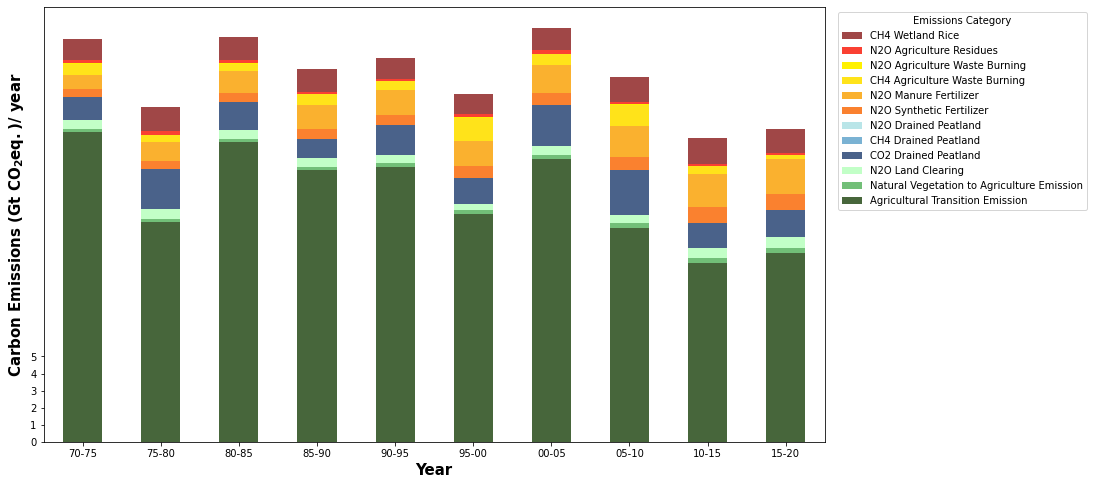

In [9]:
panel_A = pd.DataFrame(value_all_sources_process, index=tahun, columns=columns1)
ax1 = panel_A.plot(kind='bar', stacked=True, color=colors1, figsize=(14, 8), legend=False)

plt.xlabel('Year', fontweight='bold', fontsize=15)
plt.ylabel(r"$\bf{Carbon\ Emissions\ (Gt~CO_2 eq.)/\ year}$", fontsize=15)
plt.xticks([r for r in range(len(tahun))], tahun, rotation=0)
plt.axhline(0, color='black', linewidth=0.8)

yticks = np.arange(0, 6, 1)
plt.yticks(yticks)

handles = []
handles, labels = ax1.get_legend_handles_labels()
labels.append('Average annual emission (Gt CO2/ year)')

order1 = [11,10,9,8,7,6,5,4,3,2,1,0]
ax1.legend([handles[idx] for idx in order1], [labels[idx] for idx in order1], title='Emissions Category', loc='upper left', bbox_to_anchor=(1.01, 1.0), ncol=1)
plt.show()


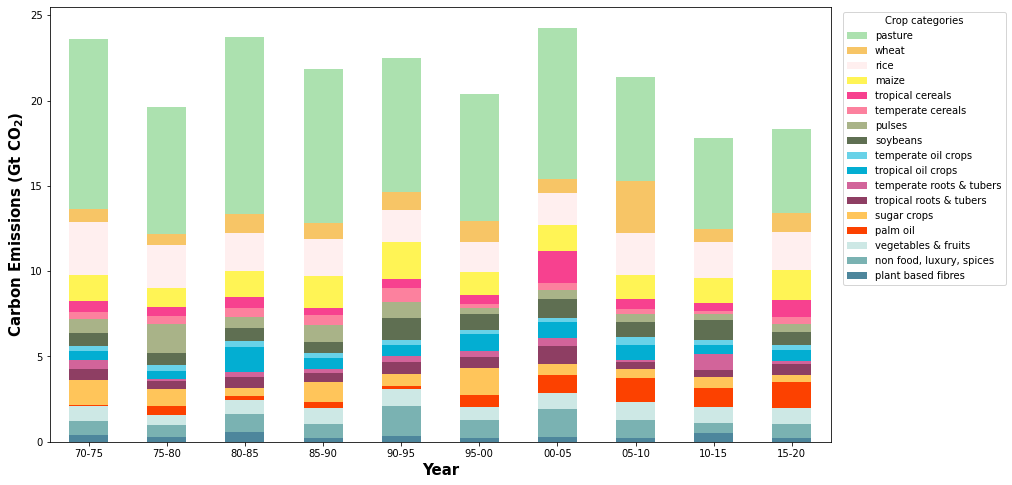

In [10]:
panel_B = pd.DataFrame(value_all_sources_crops, index=tahun, columns=columns2)
ax2 = panel_B.plot(kind='bar', stacked=True, color=colors2, figsize=(14, 8), legend=False)
plt.xlabel('Year', fontweight='bold', fontsize=15)
plt.ylabel(r"$\bf{Carbon\ Emissions\ (Gt~CO_2)}$", fontsize=15)
plt.xticks([r for r in range(len(tahun))], tahun, rotation=360)
plt.axhline(0, color='black', linewidth=0.8)

handles, labels = ax2.get_legend_handles_labels()
labels.append('Average annual emission (Gt CO2/ year)')

order2 = [16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
ax2.legend([handles[idx] for idx in order2], [labels[idx] for idx in order2], title='Crop categories', loc='upper right', bbox_to_anchor=(1.23, 1.0), ncol=1)

plt.show()

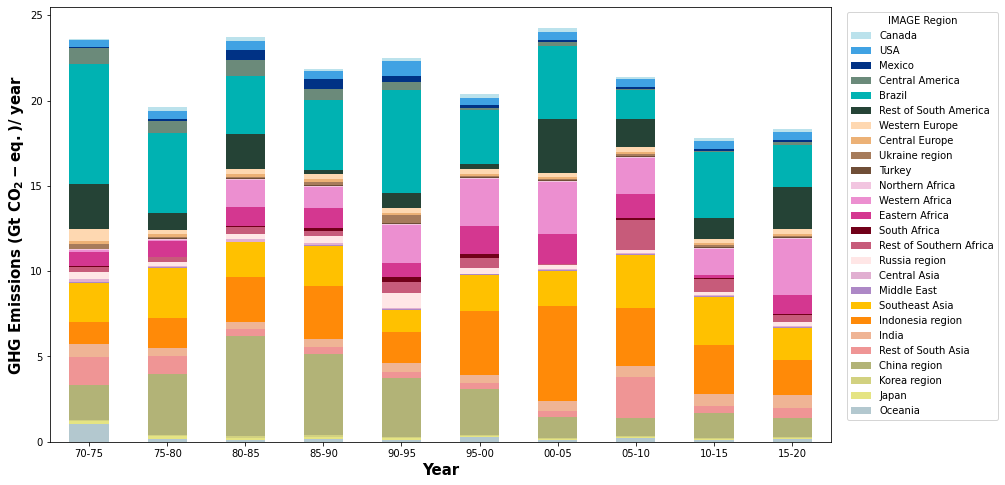

In [11]:
panel_C = pd.DataFrame(value_all_sources_region, index=tahun, columns=columns3)
ax3 = panel_C.plot(kind='bar', stacked=True, color=colors3, figsize=(14, 8), legend=False)

plt.xlabel('Year', fontweight='bold', fontsize=15)
plt.ylabel(r"$\bf{GHG\ Emissions\ (Gt~CO_2-eq.)/\ year}$", fontsize=15)
plt.xticks([r for r in range(len(tahun))], tahun, rotation=360)
plt.axhline(0, color='black', linewidth=0.8)

handles, labels = ax3.get_legend_handles_labels()
order3 = [25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
ax3.legend([handles[idx] for idx in order3], [labels[idx] for idx in order3], title='IMAGE Region', loc='upper right', bbox_to_anchor=(1.22, 1.0), ncol=1)
plt.show()

Combine PANEL A, B, C

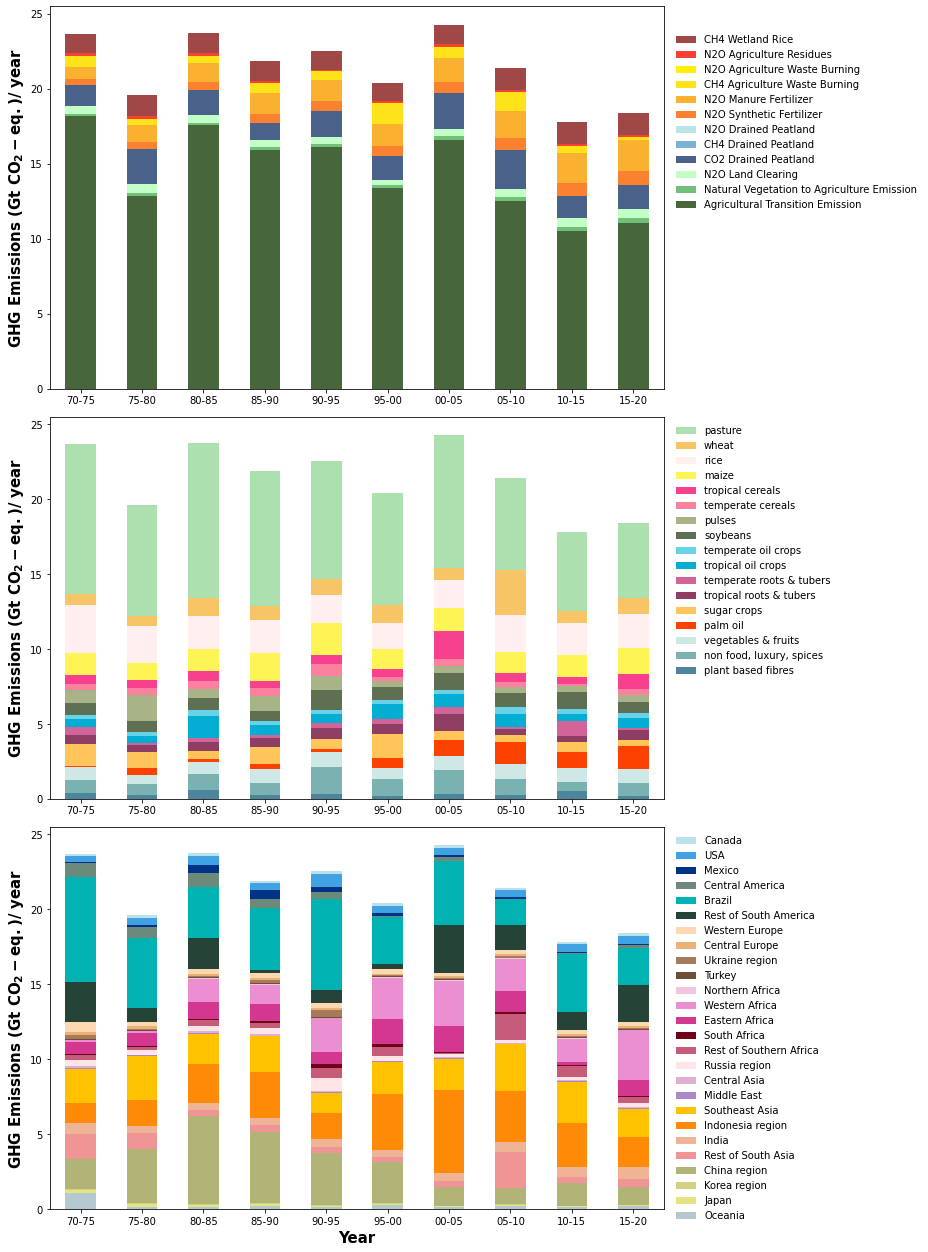

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(13, 18))
axs[0] = panel_A.plot(kind='bar', stacked=True, color=colors1, ax=axs[0], legend=False)
axs[0].set_ylabel(r"$\bf{GHG\ Emissions\ (Gt~CO_2-eq.)/\ year}$", fontsize=15)
axs[0].set_xticks([r for r in range(len(tahun))])
axs[0].set_xticklabels(tahun, rotation=0)
axs[0].axhline(0, color='black', linewidth=0.8)

axs[1] = panel_B.plot(kind='bar', stacked=True, color=colors2, ax=axs[1], legend=False)
axs[1].set_ylabel(r"$\bf{GHG\ Emissions\ (Gt~CO_2-eq.)/\ year}$", fontsize=15)
axs[1].set_xticks([r for r in range(len(tahun))])
axs[1].set_xticklabels(tahun, rotation=360)
axs[1].axhline(0, color='black', linewidth=0.8)

axs[2] = panel_C.plot(kind='bar', stacked=True, color=colors3, ax=axs[2], legend=False)
axs[2].set_ylabel(r"$\bf{GHG\ Emissions\ (Gt~CO_2-eq.)/\ year}$", fontsize=15)
axs[2].set_xticks([r for r in range(len(tahun))])
axs[2].set_xticklabels(tahun, rotation=360)
axs[2].axhline(0, color='black', linewidth=0.8)
axs[2].set_xlabel('Year', fontweight='bold', fontsize=15)

bbox_transform = fig.transFigure
plt.rc('text', usetex=False)

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend([handles1[idx] for idx in order1], [labels1[idx] for idx in order1] ,edgecolor='white',loc='upper left', bbox_to_anchor=(1.005, 0.95))

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend([handles2[idx] for idx in order2], [labels2[idx] for idx in order2], edgecolor='white', loc='upper left', bbox_to_anchor=(1.005, 1), ncol=1)

handles3, labels3 = axs[2].get_legend_handles_labels()
axs[2].legend([handles3[idx] for idx in order3], [labels3[idx] for idx in order3],edgecolor='white', loc='upper left', bbox_to_anchor=(1.005, 1), ncol=1)

plt.subplots_adjust(hspace=0.001)
plt.tight_layout()
plt.show()